# Introduction
## Content:
- Aim: To show how to use BayesRTO.py
1. Apply BayesRTO on Benoit Problem

In [1]:
import numpy as np
import random
from scipy.optimize import minimize
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import BayesRTO
import Benoit_Problem
import pandas as pd
import imageio.v2 as imageio
import os
from IPython.display import Image

ModuleNotFoundError: No module named 'BayesRTOjax'

# 1. Benoit Problem
## A. Code for Drawings and GIFs

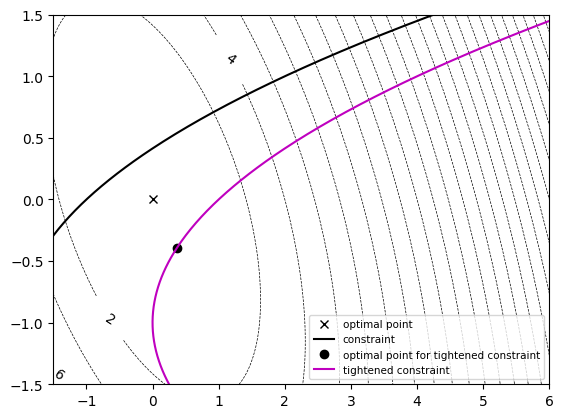

In [ ]:
# Plot for objective function 
def plant_drawing(is_constraint,is_tight_constraint):
        delta = 0.01
        x = np.arange(-6.5, 6.5, delta)
        y = np.arange(-6.5, 6.5, delta)
        u = np.meshgrid(x, y)
        levels = np.linspace(0,50,26)

        CS1 = plt.contour(u[0],u[1],Benoit_Problem.Benoit_System_1(u),levels,colors='k',linestyles = "dashed",linewidths = 0.5)
        plt.clabel(CS1,inline=True)
        plt.axis((-1.5, 6.0, -1.5, 1.5))

        if is_constraint == True:
                plt.plot(0,0,'kx')
                
                # Plot for constraint
                uc0 = 1. + x**2 + 2.*x - 2.
                constraint1 = plt.plot(uc0,x,'k')

        if is_tight_constraint == True:
                # Plot for optimal value for optimization with tightened constraint
                plt.plot(0.36845785, -0.39299271,'ko')

                # Plot for tightened constraint
                uc0t = 1. + x ** 2 + 2. * x
                constraint2 = plt.plot(uc0t,x,'m')

# Plot trust region circle
def trustregion_drawing(r,input_0,input_1):
       
        d_trial_x = np.linspace(-r, r, 50)
        d_trial_ypos= []
        d_trial_yneg = []
        equations = lambda d: [r - np.linalg.norm(d),d[0] - j]
        for j in d_trial_x: 
                initial_guess = [0,0]
                d = fsolve(equations,initial_guess)
                d_trial_ypos.append(d[1])
                d_trial_yneg.append(-d[1])

        d_trial_ypos = np.array(d_trial_ypos)
        d_trial_yneg = np.array(d_trial_yneg)

        plt.plot(d_trial_x+input_0,d_trial_ypos+input_1,'k-',linewidth=0.5)
        plt.plot(d_trial_x+input_0,d_trial_yneg+input_1,'k-',linewidth=0.5)

def BRTO_Benoit_drawing(data):
        plt.figure()
        # Drawing for Benoit's Problem
        plant_drawing(is_constraint = False,is_tight_constraint = True)

        # Plot points for input observed
        plt.plot(data['input_0'],data['input_1'], 'ro')
        plt.plot(data['input_0'],data['input_1'],'b-',linewidth=1,label='_nolegend_')

        n_iter = len(data['input_0'])
        for i in range(n_iter):
                trustregion_drawing(data['r'][i],data['input_0'][i],data['input_1'][i])

def create_frame(fun_drawing,t,filename):
        fun_drawing
        plt.savefig(filename)
        plt.close()

def create_GIF(frame_duration,filenames,GIFname):
        # create a GIF from saved frames
        frame_duration = 1000
        with imageio.get_writer(GIFname, mode='I', duration=frame_duration) as writer:
                for filename in filenames:
                        image = imageio.imread(filename)
                        writer.append_data(image)
        # remove individual frame files
        for filename in filenames:
                os.remove(filename)

# plant_drawing(is_constraint=True,is_tight_constraint=False)
plant_drawing(is_constraint=True,is_tight_constraint=True)
plt.legend(["optimal point",
            "constraint",
            'optimal point for tightened constraint',
            'tightened constraint'],
                fontsize = 7.5)
plt.show()



## B. Without Uncertainty

In [ ]:
###################################################################################
###########################______GP Initialization______###########################
###################################################################################
'''
Description:
    It does as follows:
    1. Collects samples
    2. Find optimal parameters
    3. Initializes GP.
Arguments:
    n_sample        : number of samples to collect your input for GP initialization
    u_0             : initial input u (center point of area where you collect  of samples)
    theta_0         : initial parameter values for model [parameters for obj fun, parameters for constraint 1, parameters for constraint 2,...]
    r               : initial radius of trust region
    plant_system    : array with elements of plant objective function and constraints
    model           : array with elements of model objective function and constraints
Returns:
    GP_m            : a Gaussian Process Model
'''
BRTO = BayesRTOjax.Bayesian_RTO()
np.random.seed(42)
random.seed(42)

n_sample            = 4
u_0                 = np.array([6.,1,])
theta_0             = np.array([1.5,1.,1.5,1.])
r                   = 0.5
plant_system        = [Benoit_Problem.Benoit_System_1,
                       Benoit_Problem.con1_system_tight]
model               = [Benoit_Problem.Benoit_Model_1,
                       Benoit_Problem.con1_Model]

theta,GP_m = BRTO.GP_Initialization(n_sample,u_0,theta_0,r,plant_system,model)

#######################################################################################
###########################______Bayesian Optimization______###########################
#######################################################################################
'''
'''
n_iter = 20
b = 0
# Dictionary for data collection
data = {}
data['input_0'] = [u_0[0]]
data['input_1'] = [u_0[1]]
data['plant output'] = [plant_system[0](u_0)]
data['plant constraint'] = [plant_system[1](u_0)]
data['model output'] = [model[0](theta,u_0,GP_m=GP_m)]
data['model constraint'] = [model[1](theta,u_0,GP_m=GP_m)]
data['r'] = [r]
# Parameters for GIF
filenames = []

for i in range(n_iter):
    # Create Frame
    t = i * 0.1
    filename = f'frame_{i:02d}.png'
    create_frame(BRTO_Benoit_drawing(data),t,filename)
    filenames.append(filename)

    # Bayesian Optimization
    d_new = BRTO.optimize_acquisition(r,u_0,theta,GP_m,b)     # New observation
    u_new = u_0 + d_new                                     # Collect data (u_new,modifier) on new observation
    modifier = BRTO.modifier_calc(theta,u_new)
    GP_m.add_sample(u_new,modifier)                         # Improve GP model using collected data on new observation
    u_0 = u_new                                             # For next iteration

    # Data Collection
    data['input_0'].append(u_new[0])
    data['input_1'].append(u_new[1])
    data['plant output'].append(plant_system[0](u_new))
    data['plant constraint'].append(plant_system[1](u_new))
    data['model output'].append(model[0](theta,u_new,GP_m=GP_m))
    data['model constraint'].append(model[1](theta,u_new,GP_m=GP_m))
    data['r'].append(r)

    if i == n_iter-1:
        # Create Last Frame
        t = n_iter * 0.1
        filename = f'frame_{n_iter:02d}.png'
        create_frame(BRTO_Benoit_drawing(data),t,filename)
        filenames.append(filename)

# Create GIF
frame_duration = 1000
GIFname = 'BRTO_Benoit.gif'
create_GIF(frame_duration,filenames,GIFname)

print(f"Final input: {data['input_0'][-1],data['input_1'][-1]}")

/Users/donggyulee/anaconda3/envs/myenv/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Final input: (0.36667941564399414, -0.39445769462763636)


### Graphical Illustration

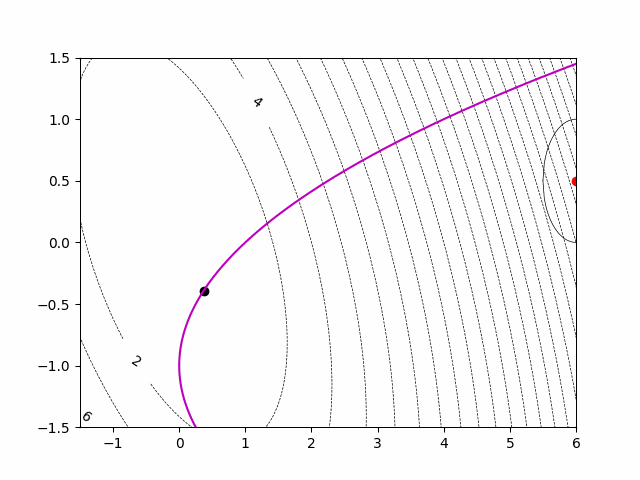

In [ ]:
Image(filename='BRTO_Benoit.gif')

In [ ]:
pd.DataFrame(data)

,input_0,input_1,plant output,plant constraint,model output,model constraint,r
0,6.000000,0.500000,39.250000,3.750000e+00,38.976801,3.866096e+00,0.5
1,5.548978,0.284177,32.448811,3.899867e+00,32.448811,3.899871e+00,0.5
2,5.071046,0.137274,26.430473,3.777654e+00,26.430466,3.777654e+00,0.5
3,4.575088,0.073827,21.274644,3.421983e+00,21.274657,3.421979e+00,0.5
4,4.075088,0.073141,16.909751,2.923456e+00,16.909751,2.923456e+00,0.5
5,3.578418,0.015529,12.860891,2.547118e+00,12.860891,2.547119e+00,0.5
6,3.082592,-0.048935,9.353918,2.178067e+00,9.354356,2.178065e+00,0.5
7,2.589071,-0.129167,6.385548,1.830722e+00,6.385552,1.830717e+00,0.5
8,2.113522,-0.283612,3.947990,1.600311e+00,3.948007,1.600307e+00,0.5
9,1.626306,-0.395953,2.157708,1.261433e+00,2.157713,1.261426e+00,0.5


## Can find following informations

In [ ]:
# 1. Input samples initially created by number n_sample(argument) and used to initialize GP
print(f"Initial Input Sample: \n {BRTO.input_sample}")

Initial Input Sample: 
 [[6.77035371 0.28556597]
 [6.06189051 0.6455346 ]
 [5.62915731 0.12918331]
 [6.42493319 0.70650066]]
